In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyhf

np.random.seed(0)
plt.rcParams.update({"font.size": 14})

In [2]:
ns = 1.0
nb = 0.0
bgError = 0.0
model = pyhf.simplemodels.uncorrelated_background(
    signal=[ns], bkg=[nb], bkg_uncertainty=[bgError]
)

In [3]:
unbounded_bounds = model.config.suggested_bounds()
unbounded_bounds[model.config.poi_index] = (-10, 10)

bounded_bounds = model.config.suggested_bounds()
print(bounded_bounds)

[(0, 10), (1e-10, 10.0)]


In [4]:
true_poi = 1.0
n_toys = 300
toys = model.make_pdf(pyhf.tensorlib.astensor([true_poi, 1.0])).sample((n_toys,))

In [5]:
pars = np.asarray(
    [pyhf.infer.mle.fit(toy, model, par_bounds=unbounded_bounds) for toy in toys]
)
fixed_params = model.config.suggested_fixed()

In [6]:
test_poi = 0.0
tmu = np.asarray(
    [
        pyhf.infer.test_statistics.tmu(
            test_poi,
            toy,
            model,
            init_pars=model.config.suggested_init(),
            par_bounds=unbounded_bounds,
            fixed_params=fixed_params,
        )
        for toy in toys
    ]
)

/home/lessa/.local/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [7]:
tmu_tilde = np.asarray(
    [
        pyhf.infer.test_statistics.tmu_tilde(
            test_poi,
            toy,
            model,
            init_pars=model.config.suggested_init(),
            par_bounds=bounded_bounds,
            fixed_params=fixed_params,
        )
        for toy in toys
    ]
)

qmu = np.asarray(
    [
        pyhf.infer.test_statistics.qmu(
            test_poi,
            toy,
            model,
            init_pars=model.config.suggested_init(),
            par_bounds=unbounded_bounds,
            fixed_params=fixed_params,
        )
        for toy in toys
    ]
)

qmu_tilde = np.asarray(
    [
        pyhf.infer.test_statistics.qmu_tilde(
            test_poi,
            toy,
            model,
            init_pars=model.config.suggested_init(),
            par_bounds=bounded_bounds,
            fixed_params=fixed_params,
        )
        for toy in toys
    ]
)

In [8]:
muhat = pars[:, model.config.poi_index]
muhat_sigma = np.std(muhat)

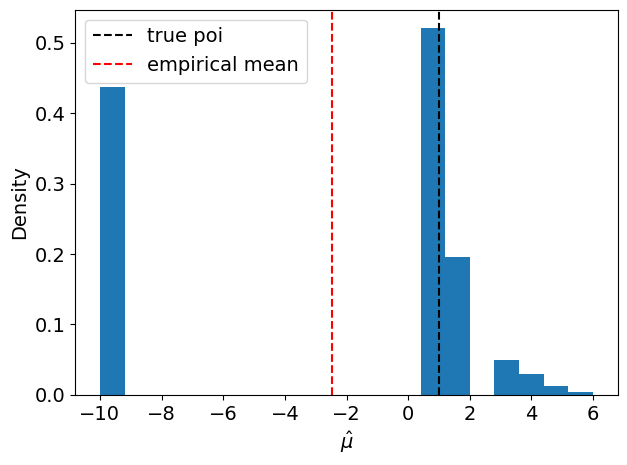

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 5)

ax.set_xlabel(r"$\hat{\mu}$")
ax.set_ylabel("Density")
# ax.set_ylim(top=0.5)

ax.hist(muhat, bins=20, density=True)
ax.axvline(true_poi, label="true poi", color="black", linestyle="dashed")
ax.axvline(np.mean(muhat), label="empirical mean", color="red", linestyle="dashed")
ax.legend();

In [10]:
def tmu_asymp(mutest, muhat, sigma):
    return (mutest - muhat) ** 2 / sigma**2


def tmu_tilde_asymp(mutest, muhat, sigma):
    a = tmu_asymp(mutest, muhat, sigma)
    b = tmu_asymp(mutest, muhat, sigma) - tmu_asymp(0.0, muhat, sigma)
    return np.where(muhat > 0, a, b)


def qmu_asymp(mutest, muhat, sigma):
    return np.where(
        muhat < mutest, tmu_asymp(mutest, muhat, sigma), np.zeros_like(muhat)
    )


def qmu_tilde_asymp(mutest, muhat, sigma):
    return np.where(
        muhat < mutest, tmu_tilde_asymp(mutest, muhat, sigma), np.zeros_like(muhat)
    )

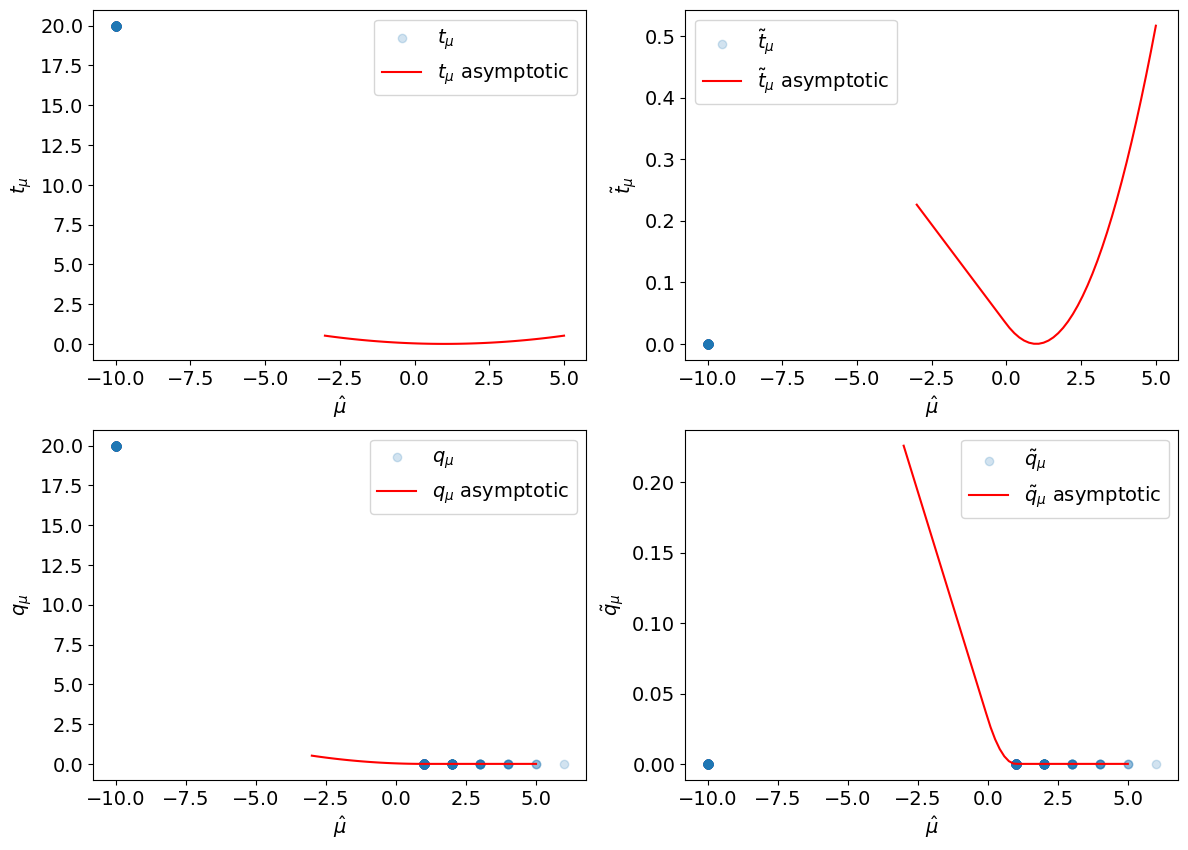

In [11]:
muhat_asymp = np.linspace(-3, 5)
fig, axarr = plt.subplots(2, 2)
fig.set_size_inches(14, 10)

labels = [r"$t_{\mu}$", "$\\tilde{t}_{\\mu}$", r"$q_{\mu}$", "$\\tilde{q}_{\\mu}$"]
data = [
    (tmu, tmu_asymp),
    (tmu_tilde, tmu_tilde_asymp),
    (qmu, qmu_asymp),
    (qmu_tilde, qmu_tilde_asymp),
]

for ax, (label, d) in zip(axarr.ravel(), zip(labels, data)):
    empirical, asymp_func = d
    ax.scatter(muhat, empirical, alpha=0.2, label=label)
    ax.plot(
        muhat_asymp,
        asymp_func(1.0, muhat_asymp, muhat_sigma),
        label=f"{label} asymptotic",
        c="r",
    )
    ax.set_xlabel(r"$\hat{\mu}$")
    ax.set_ylabel(f"{label}")
    ax.legend(loc="best")